In [1]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
from utils import make_compare_plot,plot_cdf,plot_pdf
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.preprocessing import MinMaxScaler

In [2]:
data = pd.read_csv("adult_train.csv")

data_sample = pd.read_csv("adult_train_sample.csv")

# 
its_MS = pd.read_csv("generated/strong/ITS/sample_data_1_699_0.csv")
its_linear = pd.read_csv("results/its_sample.csv")
its_complex = pd.read_csv("generated/complex/ITS/sample_data_1_699_0.csv")


baseline_VAE = pd.read_csv("../VAE/expdir/adult/sample_data_vae_699_0.csv")
baseline_VAE.columns = data.columns.tolist()


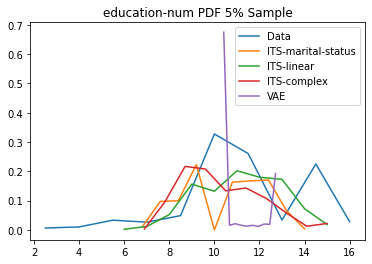

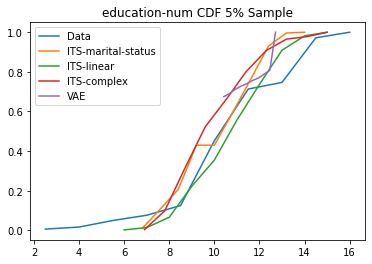

In [4]:
make_compare_plot([data,its_MS,its_linear,its_complex,baseline_VAE],"education-num",plot_pdf,["Data","ITS-marital-status","ITS-linear","ITS-complex","VAE"],"education-num PDF 5% Sample")
make_compare_plot([data,its_MS,its_linear,its_complex,baseline_VAE],"education-num",plot_cdf,["Data","ITS-marital-status","ITS-linear","ITS-complex","VAE"],"education-num CDF 5% Sample")

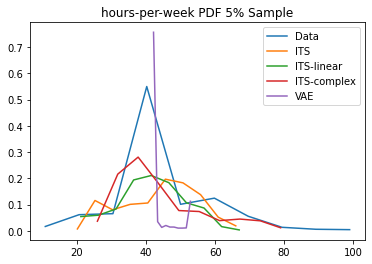

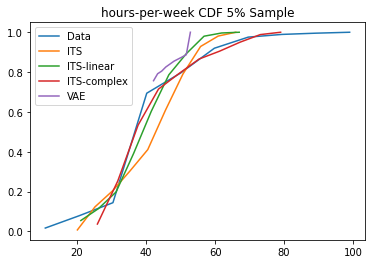

In [5]:
make_compare_plot([data, its_MS,its_linear,its_complex,baseline_VAE],"hours-per-week",plot_pdf,["Data","ITS","ITS-linear","ITS-complex","VAE"],"hours-per-week PDF 5% Sample")
make_compare_plot([data, its_MS,its_linear,its_complex,baseline_VAE],"hours-per-week",plot_cdf,["Data","ITS","ITS-linear","ITS-complex","VAE"],"hours-per-week CDF 5% Sample")

In [ ]:
data.dtypes

## Machine Learning Performance

In [37]:
baseline_VAE

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,38.621200,Private,190635.62,HS-grad,10.160583,Never-married,Other-service,Not-in-family,White,Male,1116.7393,97.754480,40.980152,United-States,<=50K
1,38.623005,Private,190649.20,HS-grad,10.160589,Married-civ-spouse,Craft-repair,Husband,White,Male,1116.8110,97.754486,41.002163,United-States,<=50K
2,51.717278,Private,190640.81,HS-grad,10.160583,Married-civ-spouse,Craft-repair,Husband,White,Male,1116.7393,97.754480,40.980343,United-States,<=50K
3,51.107895,Private,190636.06,Some-college,10.160584,Married-civ-spouse,Other-service,Not-in-family,White,Female,1116.7401,97.754480,40.980186,United-States,<=50K
4,38.739220,Private,190647.52,Bachelors,12.712647,Never-married,Prof-specialty,Not-in-family,White,Female,1116.7393,97.754490,41.027374,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1502,51.717308,Private,190639.89,Bachelors,12.033046,Married-civ-spouse,Exec-managerial,Husband,White,Male,1131.1900,97.754520,52.841705,United-States,>50K
1503,38.621200,Private,190639.52,Bachelors,12.712647,Never-married,Prof-specialty,Not-in-family,White,Male,1116.7394,97.754480,40.987750,United-States,<=50K
1504,38.621120,Private,293139.80,Some-college,10.339102,Never-married,Craft-repair,Husband,White,Male,1116.7504,97.755000,41.045948,United-States,<=50K
1505,38.621970,Private,190654.48,HS-grad,10.160583,Married-civ-spouse,Craft-repair,Husband,White,Male,1116.7393,97.754480,40.983505,United-States,<=50K


In [6]:
def convert_type(data,columns):
    data = data[columns].astype('category')
    for col in columns:
        data[col] = data[col].cat.codes
    return data

In [7]:
data["label"] = "data"
its_MS["label"] = "its"
# fds["label"] = "fds"
# mean_loss["label"] = "mean_loss"
its_linear["label"] = "its_linear"
its_complex["label"] = "its_complex"
baseline_VAE["label"] = "VAE"
data_sample["label"] = "sample"

full = pd.concat([data,data_sample, its_MS,its_linear,its_complex,baseline_VAE])

In [8]:
full[['workclass','education', 
       'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country','income']] = convert_type(full,['workclass','education', 
       'marital-status', 'occupation', 'relationship', 'race', 'sex','native-country','income'])

In [9]:
data = full[full["label"] == "data"]

data_sample = full[full["label"] == "sample"]

its = full[full["label"] == "its"]
its_weak = full[full["label"] == "its_linear"]
its_complex = full[full["label"] == "its_complex"]

baseline_VAE = full[full["label"] == "VAE"]


In [135]:
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income,label
0,38.0,2,215646.0,11,9.0,0,5,1,4,1,0.0,0.0,40.0,37,0,data
1,53.0,2,234721.0,1,7.0,2,5,0,2,1,0.0,0.0,40.0,37,0,data
2,28.0,2,338409.0,9,13.0,2,9,5,2,0,0.0,0.0,40.0,4,0,data
3,37.0,2,284582.0,12,14.0,2,3,5,4,0,0.0,0.0,40.0,37,0,data
4,31.0,2,45781.0,12,14.0,4,9,1,4,0,14084.0,0.0,50.0,37,1,data
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30143,25.0,2,350977.0,11,9.0,4,7,3,4,0,0.0,0.0,40.0,37,0,data
30144,39.0,2,215419.0,9,13.0,0,9,1,4,0,0.0,0.0,36.0,37,0,data
30145,38.0,2,374983.0,9,13.0,2,9,0,4,1,0.0,0.0,50.0,37,0,data
30146,44.0,2,83891.0,9,13.0,0,0,3,1,1,5455.0,0.0,40.0,37,0,data


In [10]:
import numpy
from sklearn.model_selection import cross_val_score
# x is your dataset
origin_np = np.array(data)
col = list(data.columns)
indices = numpy.random.permutation(data.shape[0])
n = data.shape[0] - baseline_VAE.shape[0]
test_idx, training_idx = indices[:n], indices[n:]
training_data, test = pd.DataFrame(origin_np[training_idx,:],columns = col), pd.DataFrame(origin_np[test_idx,:],columns = col)


In [11]:
def make_prediction(response, response_type):
    train_data_y = training_data[response].astype("float64")
    train_data_X = training_data.drop(columns=[response,"label","fnlwgt"]).astype("float64")

    test_data_X = test.drop(columns=[response,"label","fnlwgt"]).astype("float64")
    test_data_y = test[response].astype("float64")


    train_data_sample_X = data_sample.drop(columns=[response,"label","fnlwgt"]).astype("float64")
    train_data_sample_y = data_sample[response].astype("float64")


    # ITS-Linear
    train_its_weak_X = its_weak.drop(columns=[response,"label","fnlwgt"]).astype("float64")
    train_its_weak_y = its_weak[response].astype("float64")

    # origin ITS Loss
    train_its_X = its.drop(columns=[response,"label","fnlwgt"]).astype("float64")
    train_its_y = its[response].astype("float64")


    # ITS-complex
    train_its_complex_X = its_complex.drop(columns=[response,"label","fnlwgt"]).astype("float64")
    train_its_complex_y = its_complex[response].astype("float64")

    # VAE baseline
    train_VAE_X = baseline_VAE.drop(columns=[response,"label","fnlwgt"]).astype("float64")
    train_VAE_y = baseline_VAE[response].astype("float64")

    result = []

    if response_type == "clf":

        clf = xgb.XGBClassifier(eval_metric='mlogloss')

        clf.fit(train_data_X, train_data_y)
        #result.append(cross_val_score(clf, test_data_X,test_data_y, cv=3).mean())
        result.append(clf.score(test_data_X,test_data_y))

        clf.fit(train_data_sample_X, train_data_sample_y)
        result.append(clf.score(test_data_X,test_data_y))

        clf.fit(train_its_weak_X, train_its_weak_y)
        result.append(clf.score(test_data_X,test_data_y))

        clf.fit(train_its_X, train_its_y)
        result.append(clf.score(test_data_X,test_data_y))

        clf.fit(train_its_complex_X, train_its_complex_y)
        result.append(clf.score(test_data_X,test_data_y))

        try:
            clf.fit(train_VAE_X, train_VAE_y)
            result.append(clf.score(test_data_X,test_data_y))
        except:
            result.append(np.nan)


    else:
        clf = xgb.XGBRegressor(eval_metric='mlogloss')

        clf.fit(train_data_X, train_data_y)
        result.append(clf.score(test_data_X,test_data_y))

        clf.fit(train_data_sample_X, train_data_sample_y)
        result.append(clf.score(test_data_X,test_data_y))

        clf.fit(train_its_weak_X, train_its_weak_y)
        result.append(clf.score(test_data_X,test_data_y))

        clf.fit(train_its_X, train_its_y)
        result.append(clf.score(test_data_X,test_data_y))

        clf.fit(train_its_complex_X, train_its_complex_y)
        result.append(clf.score(test_data_X,test_data_y))

        try:
            clf.fit(train_VAE_X, train_VAE_y)
            result.append(clf.score(test_data_X,test_data_y))
        except:
            result.append(np.nan)

    return result

    


In [12]:
def make_prediction_diff(response, response_type):
    train_data_y = training_data[response].astype("float64")
    train_data_X = training_data.drop(columns=[response,"label","fnlwgt"]).astype("float64")

    test_data_X = test.drop(columns=[response,"label","fnlwgt"]).astype("float64")
    test_data_y = test[response].astype("float64")
    
    # Data_sample
    train_data_sample_X = data_sample.drop(columns=[response,"label","fnlwgt"]).astype("float64")
    train_data_sample_y = data_sample[response].astype("float64")

    # ITS-Linear
    train_its_weak_X = its_weak.drop(columns=[response,"label","fnlwgt"]).astype("float64")
    train_its_weak_y = its_weak[response].astype("float64")

    # origin ITS Loss
    train_its_X = its.drop(columns=[response,"label","fnlwgt"]).astype("float64")
    train_its_y = its[response].astype("float64")


    # ITS-complex
    train_its_complex_X = its_complex.drop(columns=[response,"label","fnlwgt"]).astype("float64")
    train_its_complex_y = its_complex[response].astype("float64")

    # VAE baseline
    train_VAE_X = baseline_VAE.drop(columns=[response,"label","fnlwgt"]).astype("float64")
    train_VAE_y = baseline_VAE[response].astype("float64")

    result = []

    if response_type == "clf":

        clf = xgb.XGBClassifier(eval_metric='mlogloss')

        clf.fit(train_data_X, train_data_y)
        #result.append(cross_val_score(clf, test_data_X,test_data_y, cv=3).mean())
        ground_truth = clf.score(test_data_X,test_data_y)
        result.append(abs(ground_truth - ground_truth))

        clf.fit(train_data_sample_X, train_data_sample_y)
        result.append(abs(ground_truth - clf.score(test_data_X,test_data_y)))



        clf.fit(train_its_weak_X, train_its_weak_y)
        result.append(abs(ground_truth - clf.score(test_data_X,test_data_y)))

        clf.fit(train_its_X, train_its_y)
        result.append(abs(ground_truth - clf.score(test_data_X,test_data_y)))

        clf.fit(train_its_complex_X, train_its_complex_y)
        result.append(abs(ground_truth - clf.score(test_data_X,test_data_y)))

        try:
            clf.fit(train_VAE_X, train_VAE_y)
            result.append(abs(ground_truth - clf.score(test_data_X,test_data_y)))
        except:
            result.append(np.nan)

    else:
        clf = xgb.XGBRegressor(eval_metric='mlogloss')

        clf.fit(train_data_X, train_data_y)
        ground_truth = clf.score(test_data_X,test_data_y)
        result.append(ground_truth - ground_truth)

        clf.fit(train_data_sample_X, train_data_sample_y)
        result.append(abs(ground_truth - clf.score(test_data_X,test_data_y)))

        clf.fit(train_its_weak_X, train_its_weak_y)
        result.append(abs(ground_truth - clf.score(test_data_X,test_data_y)))

        clf.fit(train_its_X, train_its_y)
        result.append(abs(ground_truth - clf.score(test_data_X,test_data_y)))

        clf.fit(train_its_complex_X, train_its_complex_y)
        result.append(abs(ground_truth - clf.score(test_data_X,test_data_y)))

        try:
            clf.fit(train_VAE_X, train_VAE_y)
            result.append(abs(ground_truth - clf.score(test_data_X,test_data_y)))
        except:
            result.append(np.nan)

    return result

Text(0.5, 1.0, 'Elbow curve')

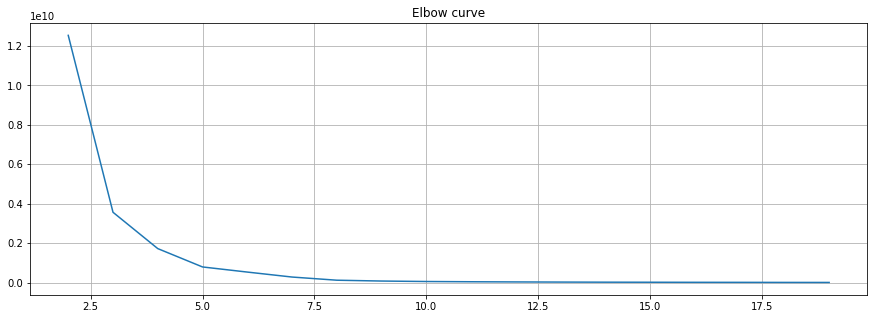

In [13]:
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.metrics.cluster import normalized_mutual_info_score

X = training_data.drop(columns=["label","fnlwgt"]).astype("float64")
distorsions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

fig = plt.figure(figsize=(15, 5))
plt.plot(range(2, 20), distorsions)
plt.grid(True)

plt.title('Elbow curve')

In [14]:
def make_clustering(n = 5):
    NMI = []

    train_data_x = training_data.drop(columns=["label","fnlwgt"]).astype("float64")

    test_data_X = test.drop(columns=["label","fnlwgt"]).astype("float64")   
    # Data_sample
    train_data_sample_X = data_sample.drop(columns=["label","fnlwgt"]).astype("float64")
    # ITS-Linear
    train_its_weak_X = its_weak.drop(columns=["label","fnlwgt"]).astype("float64")
    # origin ITS Loss
    train_its_X = its.drop(columns=["label","fnlwgt"]).astype("float64")
    # ITS-complex
    train_its_complex_X = its_complex.drop(columns=["label","fnlwgt"]).astype("float64")
    # VAE baseline
    train_VAE_X = baseline_VAE.drop(columns=["label","fnlwgt"]).astype("float64")
    
    kmeans = KMeans(n_clusters=n, random_state=0).fit(train_data_x)

    ground_truth = kmeans.predict(test_data_X)

    NMI.append(normalized_mutual_info_score(ground_truth, ground_truth))

    for data in [train_data_sample_X, train_its_weak_X, train_its_X,train_its_complex_X, train_VAE_X]:
        kmeans = KMeans(n_clusters=n, random_state=0).fit(data)
        result = kmeans.predict(test_data_X)
        NMI.append(normalized_mutual_info_score(ground_truth, result))




    return NMI

In [99]:
def hitting_rate():
 
    # Data_sample
    train_data_sample_X = data_sample.drop(columns=["label","capital-gain","fnlwgt"]).astype("float64")
    # ITS-Linear
    train_its_weak_X = its_weak.drop(columns=["label","capital-gain","fnlwgt"]).astype("float64")
    # origin ITS Loss
    train_its_X = its.drop(columns=["label","capital-gain","fnlwgt"]).astype("float64")
    # ITS-complex
    train_its_complex_X = its_complex.drop(columns=["label","capital-gain","fnlwgt"]).astype("float64")
    # VAE baseline
    train_VAE_X = baseline_VAE.drop(columns=["label","capital-gain","fnlwgt"]).astype("float64")
    distance = []
    for dataframe in [train_its_weak_X, train_its_X,train_its_complex_X, train_VAE_X]:
        sampled = dataframe.sample(n=500, random_state=1)
        sim_item = 0
        for row_sample in sampled.iterrows():
            for row_full in train_data_sample_X.iterrows():
                row_sample_data = row_sample[1]
                row_full_data = row_full[1]
                if ((row_sample_data["age"] == row_full_data["age"]) and
                (row_sample_data["workclass"] == row_full_data["workclass"]) and 
                (row_sample_data["education"] == row_full_data["education"]) and
                (row_sample_data["marital-status"] == row_full_data["marital-status"]) and
                (row_sample_data["occupation"] == row_full_data["occupation"]) and
                (row_sample_data["relationship"] == row_full_data["relationship"]) and
                (row_sample_data["race"] == row_full_data["race"]) and
                (row_sample_data["sex"] == row_full_data["sex"]) and
                (row_sample_data["native-country"] == row_full_data["native-country"]) and
                (row_sample_data["income"] == row_full_data["income"])
                ) :
                    sim_item +=1
                    break
        distance.append(sim_item)
    return distance 

        

In [106]:
sampled

,age,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
331,66.0,4.0,9.0,13.0,2.0,11.0,0.0,4.0,1.0,0.0,0.0,20.0,37.0,0.0
791,46.0,2.0,8.0,11.0,2.0,2.0,0.0,2.0,1.0,0.0,0.0,40.0,37.0,1.0
614,63.0,4.0,11.0,9.0,2.0,2.0,0.0,4.0,1.0,0.0,0.0,32.0,37.0,0.0
920,27.0,5.0,9.0,13.0,4.0,9.0,1.0,4.0,0.0,4101.0,0.0,40.0,37.0,0.0
386,41.0,2.0,11.0,9.0,2.0,3.0,0.0,4.0,1.0,0.0,0.0,40.0,37.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,45.0,2.0,9.0,13.0,2.0,9.0,0.0,4.0,1.0,0.0,0.0,40.0,20.0,0.0
707,40.0,4.0,11.0,9.0,2.0,2.0,0.0,4.0,1.0,0.0,1672.0,40.0,37.0,0.0
1481,27.0,2.0,11.0,9.0,4.0,0.0,1.0,2.0,0.0,0.0,0.0,40.0,37.0,0.0
546,50.0,2.0,11.0,9.0,2.0,9.0,0.0,4.0,1.0,99999.0,0.0,40.0,37.0,1.0


In [105]:
sampled = data_sample.sample(n=100, random_state=1)
sampled = sampled.drop(columns=["label","fnlwgt"]).astype("float64")
train_its_weak_X = its_weak.drop(columns=["label","fnlwgt"]).astype("float64")

In [137]:
def DCR():
    # Data_sample
    train_data_sample_X = data_sample.drop(columns=["label","fnlwgt"]).astype("float64")
    # ITS-Linear
    train_its_weak_X = its_weak.drop(columns=["label","fnlwgt"]).astype("float64")
    # origin ITS Loss
    train_its_X = its.drop(columns=["label","fnlwgt"]).astype("float64")
    # ITS-complex
    train_its_complex_X = its_complex.drop(columns=["label","fnlwgt"]).astype("float64")
    # VAE baseline
    train_VAE_X = baseline_VAE.drop(columns=["label","fnlwgt"]).astype("float64")
    distance = []

    scaler = MinMaxScaler()
    scaler.fit(train_data_sample_X)
    train_data_sample_X = pd.DataFrame(scaler.transform(train_data_sample_X))

    mini = []
    maxi = []

    for dataframe in [train_its_weak_X, train_its_X,train_its_complex_X, train_VAE_X]:
        distance = []
        dataframe = pd.DataFrame(scaler.transform(dataframe))
        sampled = dataframe.sample(n=100, random_state=1)
        
        for row_sample in sampled.iterrows():
            for row_full in train_data_sample_X.iterrows():
                row_sample_data = row_sample[1]
                row_full_data = row_full[1]
                distance.append(np.linalg.norm(row_sample_data-row_full_data))
        mini.append(min(distance))
        maxi.append(max(distance))
    return (maxi,mini) 

In [124]:
sampled = data_sample.sample(n=100, random_state=1)
sampled = sampled.drop(columns=["label","fnlwgt"]).astype("float64")
train_its_weak_X = its_weak.drop(columns=["label","fnlwgt"]).astype("float64")
sim_item = 0

In [131]:
scaler = MinMaxScaler()
scaler.fit(sampled)

scaled_sample = pd.DataFrame(scaler.transform(sampled))

train_its_weak_X_sample = pd.DataFrame(scaler.transform(train_its_weak_X))

In [134]:
scaled_sample

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.240741,0.00,1.000000,0.692308,0.833333,0.384615,0.2,1.0,0.0,0.052201,0.052159,0.516129,1.0,0.0
1,0.666667,0.50,0.733333,0.461538,0.333333,0.153846,0.0,1.0,1.0,0.042500,0.022659,0.500000,1.0,0.0
2,0.129630,0.25,0.400000,0.461538,0.666667,0.615385,0.4,1.0,0.0,0.039440,0.103463,0.612903,1.0,0.0
3,0.111111,0.25,0.400000,0.307692,0.666667,0.846154,0.4,1.0,0.0,0.035390,0.097478,0.709677,1.0,0.0
4,0.148148,0.25,1.000000,0.692308,0.666667,0.000000,0.2,1.0,0.0,0.050991,0.914066,0.387097,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1351,0.833333,0.00,0.666667,0.769231,0.333333,0.461538,0.0,1.0,1.0,0.058891,0.075673,0.693548,1.0,1.0
1352,0.166667,0.25,1.000000,0.692308,0.666667,0.000000,0.2,1.0,0.0,0.051851,0.286875,0.435484,1.0,0.0
1353,0.648148,1.00,0.800000,0.769231,0.166667,0.692308,0.2,1.0,0.0,0.064491,0.016246,0.532258,1.0,0.0
1354,0.129630,0.25,1.000000,0.538462,0.666667,0.000000,0.6,1.0,0.0,0.044590,1.003848,0.338710,1.0,0.0


In [15]:
prediction = {}
prediction["age"] = make_prediction("age", "reg")
prediction["workclass"] = make_prediction("workclass", "clf")
prediction["education"] = make_prediction("education", "clf")
prediction["education_num"] = make_prediction("education-num", "clf")
prediction["marital_status"] = make_prediction("marital-status", "clf")
prediction["occupation"] = make_prediction("occupation", "clf")
prediction["relationship"] = make_prediction("relationship", "clf")
prediction["race"] = make_prediction("race", "clf")
prediction["sex"] = make_prediction("sex", "clf")
prediction["capital_gain"] = make_prediction("capital-gain", "reg")
prediction["capital_loss"] = make_prediction("capital-loss", "reg")
prediction["hours_per_week"] = make_prediction("hours-per-week", "reg")
prediction["native_country"] = make_prediction("native-country", "clf")
prediction["income"] = make_prediction("income", "clf")

prediction_diff = {}
prediction_diff["age"] = make_prediction_diff("age", "reg")
prediction_diff["workclass"] = make_prediction_diff("workclass", "clf")
prediction_diff["education"] = make_prediction_diff("education", "clf")
prediction_diff["education_num"] = make_prediction_diff("education-num", "clf")
prediction_diff["marital_status"] = make_prediction_diff("marital-status", "clf")
prediction_diff["occupation"] = make_prediction_diff("occupation", "clf")
prediction_diff["relationship"] = make_prediction_diff("relationship", "clf")
prediction_diff["race"] = make_prediction_diff("race", "clf")
prediction_diff["sex"] = make_prediction_diff("sex", "clf")
prediction_diff["capital_gain"] = make_prediction_diff("capital-gain", "reg")
prediction_diff["capital_loss"] = make_prediction_diff("capital-loss", "reg")
prediction_diff["hours_per_week"] = make_prediction_diff("hours-per-week", "reg")
prediction_diff["native_country"] = make_prediction_diff("native-country", "clf")
prediction_diff["income"] = make_prediction_diff("income", "clf")

### Machine Learning utils

In [16]:
pd.DataFrame(prediction,index=["ground Truth","Sample 5%","Marital-FD","Linear-FD","Complex-FD","VAE"])

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
ground Truth,0.296061,0.709088,0.999651,1.000000,0.825530,0.274083,0.754862,0.847736,0.826822,-0.503884,-0.478115,-0.019338,0.911002,0.840124
Sample 5%,0.300107,0.716874,0.997731,0.999930,0.829929,0.307217,0.770783,0.864320,0.835306,-0.634005,-0.310206,0.049573,0.912468,0.839147
Marital-FD,-0.224921,0.535282,0.248804,0.045774,0.638141,0.146503,0.412171,0.700395,0.673475,-0.288592,-0.945397,-0.159750,0.789358,0.770539
Linear-FD,0.015676,0.551168,0.390000,0.189763,0.688873,0.125834,0.562131,0.671031,0.710485,-9.434493,-2.078955,-0.210480,0.441884,0.809294
Complex-FD,0.035204,0.633393,0.457386,0.184107,0.725463,0.174505,0.518034,0.717608,0.732446,-3.652498,-3.332087,-0.733394,0.728361,0.776893
VAE,-0.083256,NaN,0.481897,NaN,0.642505,0.267309,0.569359,NaN,0.739150,0.021347,-0.050133,-0.064673,NaN,0.794735


In [17]:
pd.DataFrame(prediction_diff,index=["ground Truth","Sample 5%","Marital-FD","Linear-FD","Complex-FD","VAE"])

,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
ground Truth,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Sample 5%,0.004047,0.007786,0.001920,0.000070,0.004399,0.033134,0.015921,0.016585,0.008484,0.130121,0.167910,0.068911,0.001466,0.000978
Marital-FD,0.520981,0.173807,0.750847,0.954226,0.187389,0.127579,0.342691,0.147341,0.153347,0.215293,0.467281,0.140412,0.121644,0.069586
Linear-FD,0.280384,0.157920,0.609651,0.810237,0.136657,0.148249,0.192731,0.176705,0.116337,8.930608,1.600840,0.191142,0.469118,0.030830
Complex-FD,0.260857,0.075696,0.542265,0.815893,0.100066,0.099578,0.236828,0.130128,0.094375,3.148614,2.853972,0.714056,0.182640,0.063231
VAE,0.379317,NaN,0.517754,NaN,0.183024,0.006774,0.185503,NaN,0.087672,0.525232,0.427983,0.045335,NaN,0.045389


### Clustering

In [18]:
from sklearn.cluster import KMeans
pd.DataFrame(make_clustering(),index=["ground Truth","Sample 5%","Marital-FD","Linear-FD","Complex-FD","VAE"],columns=["Clustering NMI"])

,Clustering NMI
ground Truth,1.000000
Sample 5%,0.865022
Marital-FD,0.723809
Linear-FD,0.558238
Complex-FD,0.719364
VAE,0.571404


### Approximate query processing (AQP)

AQP 
* http://dbgroup.cs.tsinghua.edu.cn/ligl/baq.pdf 
* https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9101822


### Privacy protection

#### Hitting Rate & DCR

In [100]:
similar = hitting_rate()

In [138]:
maxi,mini = DCR()

In [149]:
pd.DataFrame(np.array([similar,maxi,mini]).T,index=["Marital-FD","Linear-FD","Complex-FD","VAE"],columns=["Exactly Same data (Categorical)","Distance to the furthest record","Distance to the closest record"])

,Exactly Same data (Categorical),Distance to the furthest record,Distance to the closest record
Marital-FD,22.0,2.513696,0.035174
Linear-FD,21.0,2.684291,0.061005
Complex-FD,16.0,2.557805,0.090680
VAE,0.0,2.276016,0.042216
